## Table of Contents

- [Prework](#Prework)
    - [Visualisaton for IV and HV](#Visualisaton_for_IV_and_HV)
        - [Summary statistics](#Summary_statistics)
        - [Data visualization](#Data_visualization)
        - [Stationarity check](#Stationarity_check)
        - [Performance metrics](#Performance_metrics)

- [Build Model](#Build_Model)
    - [Split trainning and testing dataset using VIX](#Split_trainning_and_testing_dataset_using_VIX)
    - [Benchmark - Multi-Layer Perceptron (MLP)](#Benchmark_Multi-Layer_Perceptron_(MLP))
    - [Build the ARIMA model using IV](#Build_the_ARIMA_model_using_IV)
    - [Build ANN model - LSTM](#Build_ANN_model_LSTM)
    - [Build ANN model - GRU](#Build_ANN_model_GRU)
    - [Build LSTM-ARIMA model](#Build_LSTM-ARIMA_model)
    - [Build ARIMA-LSTM model](#Build_ARIMA-LSTM_model)
    - [Build GRU-ARIMA model](#Build_GRU-ARIMA_model)
    - [Build ARIMA-GRU model](#Build_ARIMA-GRU_model)

- [Strategies](#Strategies)
    - [Combine models prediction results](#Combine_models_prediction_results)
    - [Evaluation method: index metrics](#Evaluation_method_index_metrics)


## Prework

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from scipy.optimize import minimize
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.descriptivestats import describe
from statsmodels.tsa.stattools import adfuller as adf
import tensorflow as tf
import random as rn
import os
from scipy.stats import norm
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import arch
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import GridSearchCV
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import math
from scipy.stats import norm
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [2]:
# 文件路径
Euro_file_path = r"F:\下载\dissertation\Euro.xlsx"


# 读取 Excel 文件
Euro = pd.read_excel(Euro_file_path, index_col="Date")


### Visualisaton_for_IV_and_HV

#### Summary_statistics

In [3]:
print(Euro['Price'].describe())

count    6476.000000
mean       23.521182
std         9.358948
min        10.678300
25%        17.015800
50%        21.608250
75%        27.131375
max        87.512700
Name: Price, dtype: float64


#### Data_visualization

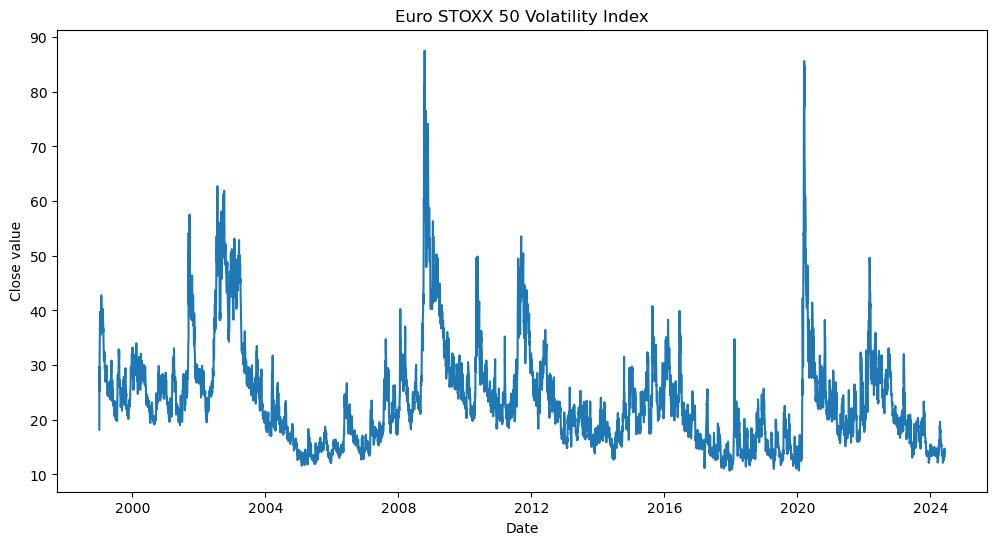

In [4]:
plt.figure(figsize=(12, 6))
# Create a line plot of the VIX close price
plt.plot(Euro.index, Euro['Price'])

# Set the title and axis labels
plt.title('Euro STOXX 50 Volatility Index')
plt.xlabel('Date')
plt.ylabel('Close value')

# Display the plot
plt.show()

#### Stationarity_check

In [5]:
Euro_close = Euro['Price'].dropna()

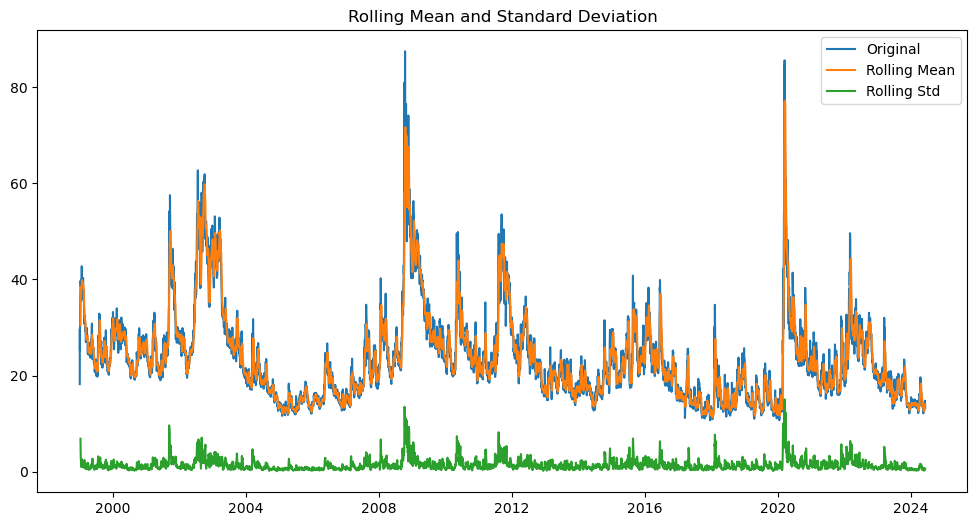

ADF Test Results:
ADF Statistic: -5.134252833237882
p-value: 1.1958014025110225e-05
Critical Values:
   1%: -3.4313655087902184
   5%: -2.8619887671862987
   10%: -2.5670088755114415
KPSS Test Results:
KPSS Statistic: 1.3277809968944208
p-value: 0.01
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739


C:\Users\lenovo\AppData\Local\Temp\ipykernel_10952\2429804082.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(timeseries, regression='c')


In [6]:
from statsmodels.tsa.stattools import adfuller, kpss

# Plot rolling mean and standard deviation
def plot_rolling_statistics(timeseries, window=7):
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, label='Original')
    plt.plot(rolmean, label='Rolling Mean')
    plt.plot(rolstd, label='Rolling Std')
    plt.legend()
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()

# Augmented Dickey-Fuller test
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print("ADF Test Results:")
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

# Kwiatkowski-Phillips-Schmidt-Shin test
def kpss_test(timeseries):
    result = kpss(timeseries, regression='c')
    print("KPSS Test Results:")
    print(f'KPSS Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:')
    for key, value in result[3].items():
        print(f'   {key}: {value}')

# Check stationarity by plotting rolling statistics and conducting tests
plot_rolling_statistics(Euro['Price'])

adf_test(Euro_close)

kpss_test(Euro_close)


#### Performance_metrics

In [7]:
# Calculate performance metrics
def evaluation(test_data, model_predictions):
    mse = mean_squared_error(test_data, model_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_data, model_predictions)
    r2 = r2_score(test_data, model_predictions)

    print("Performance Metrics:")
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("Mean Absolute Error (MAE):", mae)
    print("R-squared (R^2) Score:", r2)

## Build_Model

### Split_trainning_and_testing_dataset_using_VIX

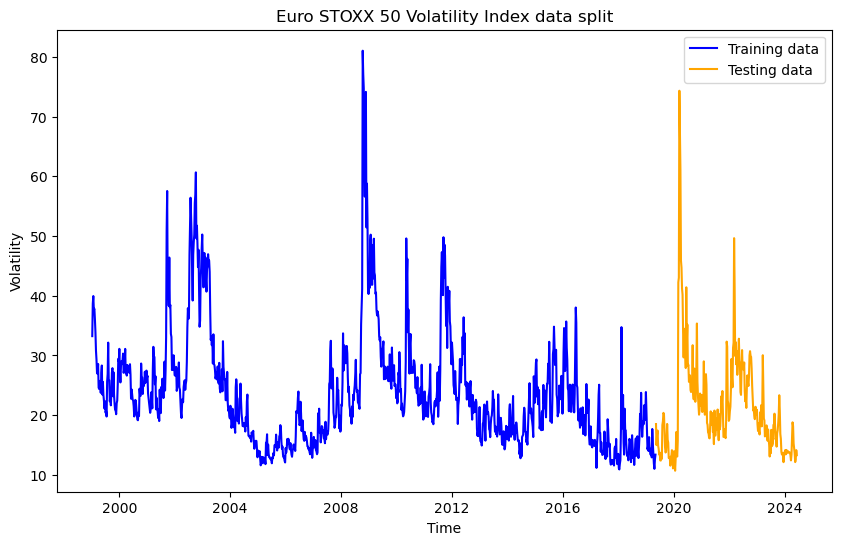

In [8]:
# Convert to the weekly dataset 
volatility_data = Euro['Price'].dropna().resample("W").last()

# Split the data into training, validation and test sets
train_size = int(len(volatility_data)*0.8)
test_size = len(volatility_data) - train_size

train_data = volatility_data[:train_size]
test_data = volatility_data[train_size:]
train_dates = train_data.index
test_dates = test_data.index

# Plot the data
plt.figure(figsize=(10,6))
plt.plot(train_data, label="Training data", color="blue")
plt.plot(test_data, label="Testing data", color="orange")
plt.title("Euro STOXX 50 Volatility Index data split")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.show()

### Benchmark_Multi-Layer_Perceptron_(MLP)

In [9]:
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider
X_train = []
y_train = []

for i in range(lookback, len(train_data_normalized)):
    X_train.append(train_data_normalized[i - lookback:i, 0])
    y_train.append(train_data_normalized[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))

# Build the MLP model
model_mlp = Sequential()
model_mlp.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))
model_mlp.add(Dense(units=32, activation='relu'))
model_mlp.add(Dense(units=1))
model_mlp.compile(optimizer='adam', loss='mean_squared_error')

# Train the MLP model
model_mlp.fit(X_train, y_train, epochs=10, batch_size=32)

# Prepare the test data
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

X_test = []
y_test = []

for i in range(lookback, len(test_data_normalized)):
    X_test.append(test_data_normalized[i - lookback:i, 0])
    y_test.append(test_data_normalized[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the input data for MLP (batch_size, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

# Make predictions on the test data
predicted_values_mlp = model_mlp.predict(X_test)
predicted_values_mlp = scaler.inverse_transform(predicted_values_mlp)


Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0160
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0047 
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0042 
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0042 
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 0.0030
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024 
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026 
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 0.0020
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 0.0027
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


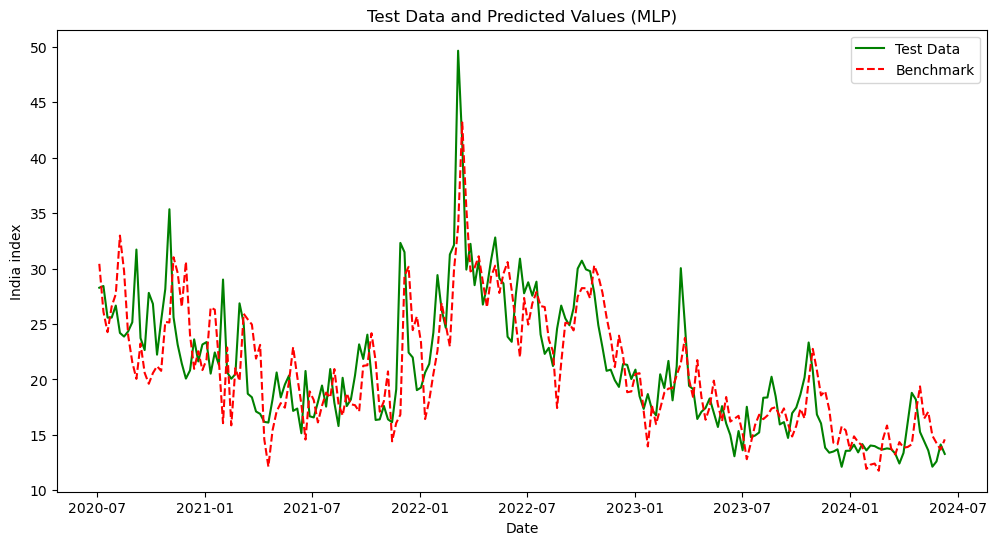

In [10]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[lookback:], test_data[lookback:], color='green', label='Test Data')
plt.plot(test_dates[lookback:], predicted_values_mlp, color='red', linestyle='dashed', label='Benchmark')
plt.title('Test Data and Predicted Values (MLP)')
plt.xlabel('Date')
plt.ylabel('India index')
plt.legend()
plt.show()

### Build_the_ARIMA_model_using_IV

Build a GARCH(1,1) model, and use the model to calculate fitted and predicted volatility of SP500 index. Plot the graph for original historical volatility and the predicted value, for the predicted value, use different color to show the fitted and predicted datasets.

In [11]:
# Train AutoARIMA model
model = auto_arima(train_data, trace=True, error_action='ignore', suppress_warnings=True)
# Fit the model
model.fit(train_data)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5638.423, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5677.672, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5658.638, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5656.764, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5675.702, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5636.365, Time=0.71 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5656.614, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5640.467, Time=0.31 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5652.870, Time=0.48 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5651.523, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5636.145, Time=0.48 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5659.000, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5638.052, Time=0.57 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5655.005, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [12]:
history = [x for x in train_data]
predicted_values_arima = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predicted_values_arima.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)


C:\Users\lenovo\AppData\Local\Temp\ipykernel_10952\792924227.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_test_value = test_data[time_point]
E:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
E:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
E:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
E:\anaconda\L

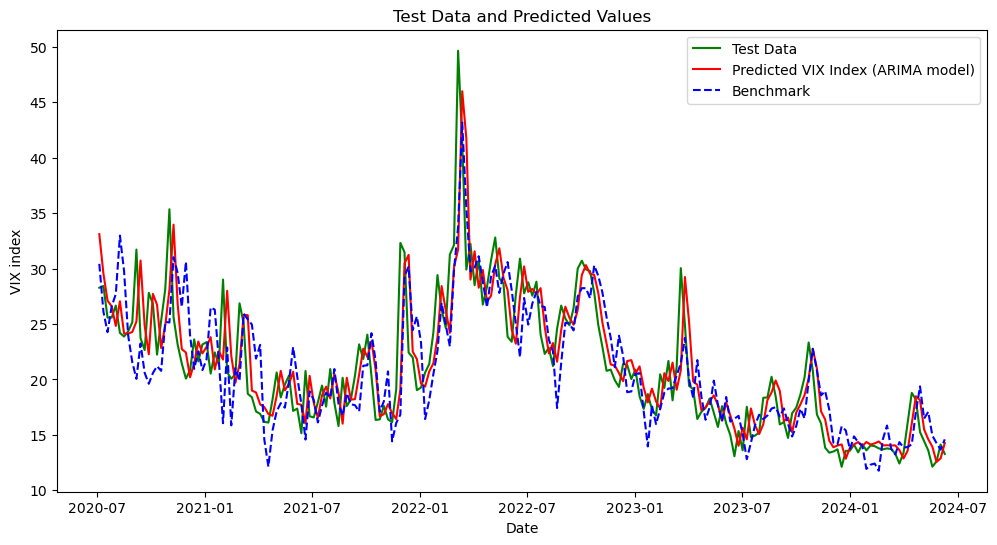

In [13]:
# Plot the graph
plt.figure(figsize=(12, 6))

# Plot the test data with a solid green line
plt.plot(test_dates[60:], test_data[60:], color='green', label='Test Data', linestyle='-')

# Plot the predicted values from the ARIMA model with a dashed red line
plt.plot(test_dates[60:], predicted_values_arima[60:], color='red', linestyle='-', label='Predicted VIX Index (ARIMA model)')

# Plot the predicted values from the MLP model with a dash-dot blue line
plt.plot(test_dates[60:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')

plt.title('Test Data and Predicted Values')
plt.xlabel('Date')
plt.ylabel('VIX index')

# Move the legend outside the plot area to avoid overlapping the lines
plt.legend()

plt.show()


In [14]:
evaluation(test_data, predicted_values_arima)

Performance Metrics:
Mean Squared Error (MSE): 17.491763248108867
Root Mean Squared Error (RMSE): 4.182315536650584
Mean Absolute Error (MAE): 2.490270074563588
R-squared (R^2) Score: 0.7678299714294158


### Build_ANN_model_LSTM

In [ ]:
#Hyperparemeter tuning: grid search for hyperparameter tuning.

Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0251
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0095
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0095
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0063
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0082
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0062
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0056
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0055
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0058
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0051
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0297
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0057
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0045
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0059
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0049
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0041
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0038
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0040
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0043
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0031
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0302
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0108
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0096
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0084
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0059
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0060
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0057
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0054
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0037
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0053
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0238
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0073
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0067
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0051
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0065
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0065
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0053
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0037
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0047
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0041
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0167
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0050
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0040
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0042
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0036
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0031
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0033
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0031
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0028
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0036
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0230
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0086
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0071
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0072
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0083
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0046
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0047
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0052
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0044
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0046
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0290
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0062
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0052
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0035
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0042
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0036
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0037
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0026
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0025
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0030
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0173
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0039
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0030
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0024
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0026
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0022
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0021
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0022
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0032
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0024
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0201
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0051
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0039
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0035
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0033
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0031
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0038
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0029
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0028
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0038
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0796
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0090
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0060
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0039
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0034
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0043
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0035
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0036
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0030
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0043
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0552
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0060
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0038
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0030
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0026
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0028
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0031
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0027
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0025
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0021
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1400
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0095
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0086
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0065
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0041
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0062
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0034
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0038
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0045
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0031
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 3.6169
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0372
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0172
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0166
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0172
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0181
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0184
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0185
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0243
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0206
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 7.0028
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2196
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0222
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0150
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0146
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0137
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0146
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0129
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0143
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0166
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 3.5824
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0701
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0248
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0299
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0251
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0376
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0264
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0318
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0270
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0239
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 11.0566
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.3791
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1093
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0561
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0261
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0190
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0184
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0172
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0372
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0241
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 7.9496
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1096
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0223
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0164
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0174
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0157
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0182
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0158
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0177
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0162
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 8.5265
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1141
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1254
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0320
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0232
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0249
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0226
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0240
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0267
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0250
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Epoch 1/20


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0179
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0094
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0072
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0078
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0061
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0046
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0070
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0051
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0052
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0049
Epoch 11/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0049
Epoch 12/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0032
Epoch 13/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0034
Epoch 14/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0035
Epoch 15/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0034
Epoch 16/20
21/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0114
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0056
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0039
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0036
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0034
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0038
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0035
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0037
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0039
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0031
Epoch 11/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0033
Epoch 12/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0026
Epoch 13/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0024
Epoch 14/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0027
Epoch 15/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0028
Epoch 16/20
21/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0424
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0093
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0106
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0066
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0068
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0069
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0055
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0049
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0053
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0055
Epoch 11/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0047
Epoch 12/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0035
Epoch 13/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0041
Epoch 14/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0059
Epoch 15/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0041
Epoch 16/20
21/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0201
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0060
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0068
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0054
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0042
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0053
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0041
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0035
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0049
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0035
Epoch 11/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0033
Epoch 12/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0034
Epoch 13/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0039
Epoch 14/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0039
Epoch 15/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0034
Epoch 16/20
21/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0159
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0043
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0037
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0037
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0035
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0039
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0035
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0029
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0028
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0034
Epoch 11/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0030
Epoch 12/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0032
Epoch 13/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0024
Epoch 14/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0025
Epoch 15/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0027
Epoch 16/20
21/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0224
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0074
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0095
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0059
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0056
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0046
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0048
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0065
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0044
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0043
Epoch 11/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0042
Epoch 12/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0039
Epoch 13/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0032
Epoch 14/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0044
Epoch 15/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0046
Epoch 16/20
21/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0193
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0066
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0044
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0037
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0039
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0034
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0041
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0035
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0034
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0028
Epoch 11/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0026
Epoch 12/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0034
Epoch 13/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0034
Epoch 14/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0038
Epoch 15/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0028
Epoch 16/20
21/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0171
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0055
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0031
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0031
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0036
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0022
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0019
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0026
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0020
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0022
Epoch 11/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0024
Epoch 12/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0020
Epoch 13/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0021
Epoch 14/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0020
Epoch 15/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0018
Epoch 16/20
21/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0476
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0098
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0049
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0039
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0043
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0041
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0048
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0045
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0034
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0034
Epoch 11/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0041
Epoch 12/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0032
Epoch 13/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0030
Epoch 14/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0035
Epoch 15/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0031
Epoch 16/20
21/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0554
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0085
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0063
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0043
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0050
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0052
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0033
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0029
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0042
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0032
Epoch 11/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0031
Epoch 12/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0027
Epoch 13/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0040
Epoch 14/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0035
Epoch 15/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0029
Epoch 16/20
21/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1802
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0056
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0043
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0040
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0039
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0040
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0033
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0037
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0029
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0026
Epoch 11/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0022
Epoch 12/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0023
Epoch 13/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0024
Epoch 14/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0020
Epoch 15/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0022
Epoch 16/20
21/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0745
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0064
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0054
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0047
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0055
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0039
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0032
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0037
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0026
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0023
Epoch 11/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0028
Epoch 12/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0026
Epoch 13/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0041
Epoch 14/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0026
Epoch 15/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0028
Epoch 16/20
21/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 5.1992
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0307
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0221
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0176
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0196
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0187
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0179
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0174
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0219
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0206
Epoch 11/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0240
Epoch 12/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0208
Epoch 13/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0197
Epoch 14/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0191
Epoch 15/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0193
Epoch 16/20
21/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.8344
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0190
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0170
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0225
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0199
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0218
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0230
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0202
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0192
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0176
Epoch 11/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0174
Epoch 12/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0160
Epoch 13/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0273
Epoch 14/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0225
Epoch 15/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0166
Epoch 16/20
21/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 5.4120
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0306
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0248
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0282
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0268
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0242
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0223
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0317
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0365
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0477
Epoch 11/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0256
Epoch 12/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0184
Epoch 13/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0302
Epoch 14/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0231
Epoch 15/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0188
Epoch 16/20
21/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 8.2670
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2166
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0571
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0253
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0157
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0186
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0211
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0227
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0172
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0187
Epoch 11/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0176
Epoch 12/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0144
Epoch 13/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0214
Epoch 14/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0235
Epoch 15/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0165
Epoch 16/20
21/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 8.7951
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0508
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0223
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0158
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0161
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0166
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0215
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0188
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0167
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0186
Epoch 11/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0169
Epoch 12/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0175
Epoch 13/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0225
Epoch 14/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0166
Epoch 15/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0205
Epoch 16/20
21/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 14.1970
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2779
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0510
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0367
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0270
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0260
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0303
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0283
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0272
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0232
Epoch 11/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0258
Epoch 12/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0240
Epoch 13/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0268
Epoch 14/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0345
Epoch 15/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0223
Epoch 16/20
21

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0188
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0094
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0074
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0062
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0068
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0053
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0050
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0053
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0056
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0070
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0291
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0069
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0055
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0053
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0048
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0040
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0043
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0043
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0038
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0043
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0284
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0129
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0088
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0078
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0062
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0074
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0085
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0066
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0074
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0077
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0237
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0108
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0070
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0068
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0066
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0055
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0054
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0061
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0067
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0042
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0188
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0077
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0050
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0044
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0043
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0039
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0039
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0040
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0033
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0035
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.0363
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0121
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0095
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0066
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0070
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0053
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0068
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0050
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0059
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0047
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0211
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0062
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0039
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0054
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0039
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0036
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0029
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0036
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0027
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0032
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0373
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0078
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0054
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0036
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0033
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0035
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0034
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0035
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0028
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0027
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0256
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0075
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0059
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0048
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0047
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0032
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0040
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0045
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0031
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0037
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0678
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0127
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0083
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0047
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0050
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0040
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0058
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0033
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0043
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0034
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.0439
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0068
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0044
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0038
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0034
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0028
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0029
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0027
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0029
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0024
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0577
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0080
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0083
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0051
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0061
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0047
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0040
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0036
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0046
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0027
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.6294
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1095
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0411
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0258
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0203
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0180
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0215
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0164
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0229
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0285
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 3.8880
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2299
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0344
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0264
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0202
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0179
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0152
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0157
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0159
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0166
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.5824
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0943
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0422
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0252
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0224
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0261
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0260
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0262
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0245
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0293
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 16.2529
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.3984
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0938
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0421
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0209
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0179
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0195
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0196
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0207
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0177
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 29.5387
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 1.8477
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.5687
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.1819
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0636
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0394
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0227
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0169
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0150
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0171
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
Epoch 1/10


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 24.9474
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.1433
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0329
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0225
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0226
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0230
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0206
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0210
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0195
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0257
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
Epoch 1/20


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0247
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0100
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0073
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0056
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0075
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0083
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0065
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0058
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0054
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0068
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0075
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0047
Epoch 13/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0047
Epoch 14/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0050
Epoch 15/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0050
Epoch 16/20
11/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0230
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0076
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0054
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0040
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0043
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0045
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0045
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0048
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0038
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0039
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0035
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0042
Epoch 13/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0032
Epoch 14/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0038
Epoch 15/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0037
Epoch 16/20
11/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0250
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0093
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0097
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0068
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0065
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0072
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0059
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0061
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0063
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0078
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0051
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0051
Epoch 13/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0050
Epoch 14/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0053
Epoch 15/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0053
Epoch 16/20
11/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0319
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0082
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0088
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0072
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0043
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0082
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0059
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0051
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0049
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0044
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0050
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0042
Epoch 13/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0046
Epoch 14/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0044
Epoch 15/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0050
Epoch 16/20
11/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0350
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0072
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0053
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0038
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0035
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0036
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0039
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0036
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0035
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0037
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0035
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0031
Epoch 13/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0037
Epoch 14/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0035
Epoch 15/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0037
Epoch 16/20
11/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0285
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0113
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0067
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0068
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0055
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0058
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0056
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0061
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0060
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0059
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0051
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0043
Epoch 13/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0036
Epoch 14/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0052
Epoch 15/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0049
Epoch 16/20
11/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0384
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0077
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0057
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0055
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0061
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0035
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0039
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0032
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0052
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0037
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0038
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0034
Epoch 13/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0036
Epoch 14/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0029
Epoch 15/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0024
Epoch 16/20
11/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0218
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0068
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0039
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0033
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0032
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0026
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0025
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0032
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0025
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0024
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0021
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0019
Epoch 13/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0021
Epoch 14/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0025
Epoch 15/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0018
Epoch 16/20
11/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0435
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0124
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0074
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0053
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0051
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0038
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0045
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0045
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0048
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0038
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0036
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0030
Epoch 13/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0032
Epoch 14/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0032
Epoch 15/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0044
Epoch 16/20
11/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0390
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0098
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0062
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0038
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0037
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0041
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0035
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0033
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0033
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0037
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0031
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0029
Epoch 13/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0032
Epoch 14/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0032
Epoch 15/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0025
Epoch 16/20
11/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0463
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0065
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0055
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0043
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0033
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0034
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0029
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0032
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0031
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0028
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0029
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0026
Epoch 13/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0022
Epoch 14/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0023
Epoch 15/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0024
Epoch 16/20
11/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0577
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0105
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0077
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0065
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0042
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0039
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0032
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0043
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0031
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0028
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0026
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0025
Epoch 13/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0027
Epoch 14/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0032
Epoch 15/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0027
Epoch 16/20
11/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 4.5856
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0323
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0210
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0181
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0210
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0190
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0158
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0169
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0186
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0176
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0193
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0171
Epoch 13/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0172
Epoch 14/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0223
Epoch 15/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0220
Epoch 16/20
11/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.6793
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0438
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0213
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0184
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0158
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0158
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0146
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0173
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0189
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0161
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0191
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0253
Epoch 13/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0223
Epoch 14/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0189
Epoch 15/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0253
Epoch 16/20
11/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.1486
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0263
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0252
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0227
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0220
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0295
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0221
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0230
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0230
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0223
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0326
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0245
Epoch 13/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0261
Epoch 14/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0259
Epoch 15/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0279
Epoch 16/20
11/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 6.6274
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0773
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0321
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0225
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0179
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0185
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0185
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0228
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0220
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0179
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0220
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0178
Epoch 13/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0263
Epoch 14/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0190
Epoch 15/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0166
Epoch 16/20
11/

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 16.7042
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.9548
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.4064
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.1519
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0638
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0293
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0187
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0195
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0173
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0174
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0153
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0167
Epoch 13/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0158
Epoch 14/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0208
Epoch 15/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0157
Epoch 16/20
11

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 17.9887
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 2.1204
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.5409
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.4263
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.3650
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.1760
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0663
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0480
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0430
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0318
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0279
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0273
Epoch 13/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0266
Epoch 14/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0238
Epoch 15/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0249
Epoch 16/20
11

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0141
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0042
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0034
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0027
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0026
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0026
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0033
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0028
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0025
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0026
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0032
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0031
Epoch 13/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0030
Epoch 14/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0022
Epoch 15/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0026
Epoch 16/20
32/

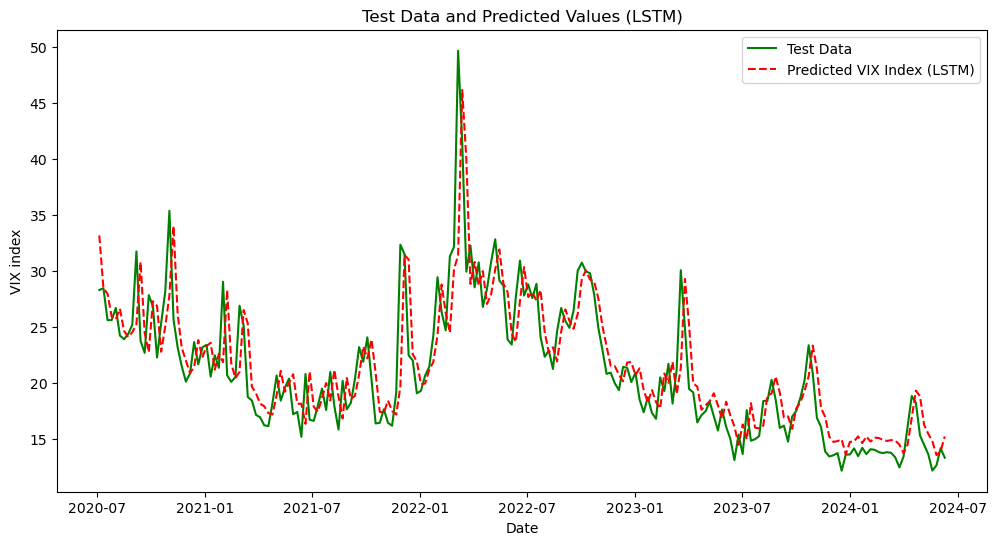

In [15]:
# Normalize the data
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider

def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data_normalized, lookback)
X_test, y_test = create_sequences(test_data_normalized, lookback)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Define the LSTM model
def create_lstm_model(units=50, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=units))
    model.add(Dense(units=1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Wrap the Keras model as a scikit-learn estimator
regressor = KerasRegressor(model=create_lstm_model, units=50, learning_rate=0.001)

# Perform hyperparameter tuning using grid search
param_grid = {
    'model__units': [50, 100], 
    'batch_size': [32, 64], 
    'epochs': [10, 20], 
    'model__learning_rate': [0.001, 0.01, 0.1]
}
model = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=3)
model.fit(X_train, y_train)

# Get the best hyperparameters
best_units = model.best_params_['model__units']
best_batch_size = model.best_params_['batch_size']
best_epochs = model.best_params_['epochs']
best_learning_rate = model.best_params_['model__learning_rate']

print(f"Best Hyperparameters: units={best_units}, batch_size={best_batch_size}, epochs={best_epochs}, learning_rate={best_learning_rate}")

# Train the LSTM model with the best hyperparameters
final_model = create_lstm_model(units=best_units, learning_rate=best_learning_rate)
final_model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size)

# Make predictions on the test data
predicted_values_lstm = final_model.predict(X_test)
predicted_values_lstm = scaler.inverse_transform(predicted_values_lstm)

# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[lookback:], test_data[lookback:], color='green', label='Test Data')
plt.plot(test_dates[lookback:], predicted_values_lstm, color='red', linestyle='dashed', label='Predicted VIX Index (LSTM)')
plt.title('Test Data and Predicted Values (LSTM)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()



In [26]:
#Best Hyperparameters: units=50, batch_size=64, epochs=20, learning_rate=0.01

In [20]:
#Optimised version
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider
X_train = []
y_train = []

for i in range(lookback, len(train_data_normalized)):
    X_train.append(train_data_normalized[i - lookback:i, 0])
    y_train.append(train_data_normalized[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(units=1))
optimizer = Adam(learning_rate=0.01)
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32)

# Prepare the test data
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

X_test = []
y_test = []

for i in range(lookback, len(test_data_normalized)):
    X_test.append(test_data_normalized[i - lookback:i, 0])
    y_test.append(test_data_normalized[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions on the test data
predicted_values_lstm = model_lstm.predict(X_test)
predicted_values_lstm = scaler.inverse_transform(predicted_values_lstm)

Epoch 1/20


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0271
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0089
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0067
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0063
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0070
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0052
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0052
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0044
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0052
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0035
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0037
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0040
Epoch 13/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0037
Epoch 14/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0036
Epoch 15/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0034
Epoch 16/20
32/

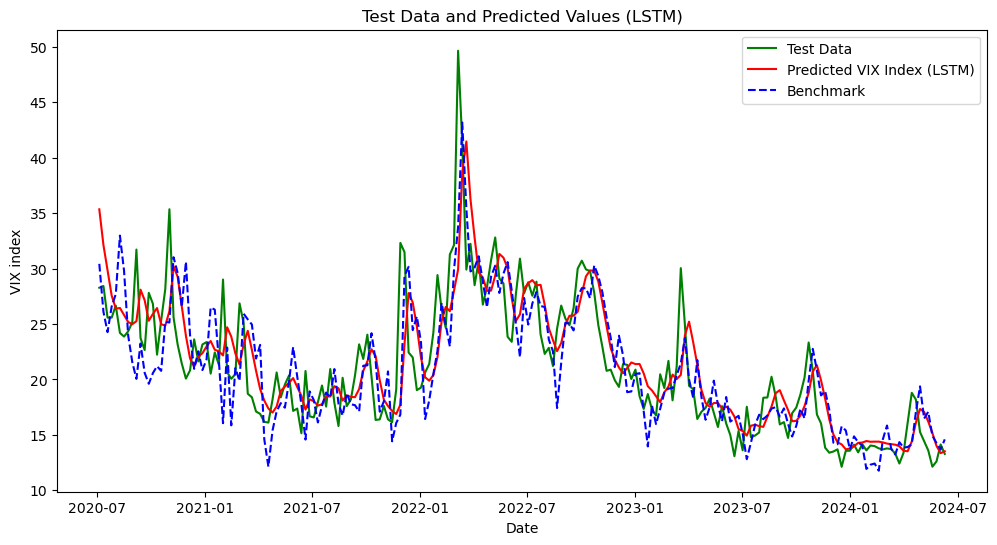

In [21]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[lookback:], test_data[lookback:], color='green', label='Test Data')
plt.plot(test_dates[lookback:], predicted_values_lstm, color='red', linestyle='-', label='Predicted VIX Index (LSTM)')
plt.plot(test_dates[lookback:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')
plt.title('Test Data and Predicted Values (LSTM)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()

In [22]:
evaluation(test_data[lookback:], predicted_values_lstm)

Performance Metrics:
Mean Squared Error (MSE): 12.480282096088068
Root Mean Squared Error (RMSE): 3.5327442726707616
Mean Absolute Error (MAE): 2.5523999661047485
R-squared (R^2) Score: 0.6405400541337778


In [23]:
evaluation(test_data[lookback:], predicted_values_mlp)

Performance Metrics:
Mean Squared Error (MSE): 15.576630858833335
Root Mean Squared Error (RMSE): 3.946724066720821
Mean Absolute Error (MAE): 2.9204241817437326
R-squared (R^2) Score: 0.5513583072734058


### Build_ANN_model_GRU

In [24]:
#Optimised version
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider
X_train = []
y_train = []

for i in range(lookback, len(train_data_normalized)):
    X_train.append(train_data_normalized[i - lookback:i, 0])
    y_train.append(train_data_normalized[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data for GRU (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the GRU model
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_gru.add(GRU(units=50))
model_gru.add(Dense(units=1))
optimizer = Adam(learning_rate=0.01)
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Train the GRU model
model_gru.fit(X_train, y_train, epochs=20, batch_size=32)

# Prepare the test data
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

X_test = []
y_test = []

for i in range(lookback, len(test_data_normalized)):
    X_test.append(test_data_normalized[i - lookback:i, 0])
    y_test.append(test_data_normalized[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the input data for GRU (batch_size, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions on the test data
predicted_values_gru = model_gru.predict(X_test)
predicted_values_gru = scaler.inverse_transform(predicted_values_gru)


Epoch 1/20


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0167
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0047
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0035
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0032
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0033
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0029
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0037
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0032
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0023
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0026
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0025
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0031
Epoch 13/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0027
Epoch 14/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0024
Epoch 15/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0022
Epoch 16/20
32/

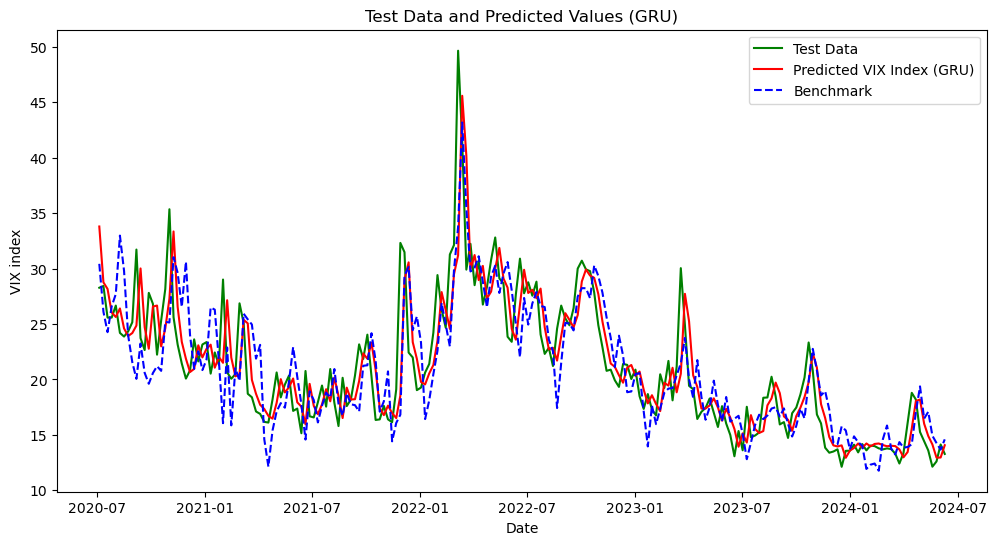

In [25]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[lookback:], test_data[lookback:], color='green', label='Test Data')
plt.plot(test_dates[lookback:], predicted_values_gru, color='red', linestyle='-', label='Predicted VIX Index (GRU)')
plt.plot(test_dates[lookback:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')


plt.title('Test Data and Predicted Values (GRU)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()

In [26]:
evaluation(test_data[lookback:], predicted_values_gru)

Performance Metrics:
Mean Squared Error (MSE): 10.254924505940119
Root Mean Squared Error (RMSE): 3.202331104982762
Mean Absolute Error (MAE): 2.2192455686402552
R-squared (R^2) Score: 0.704635313578138


### Build_LSTM-ARIMA_model

In [27]:
model1_predictions_series = pd.Series(predicted_values_arima, index=test_dates)
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(model1_predictions_series.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider
X_train = []
y_train = []

for i in range(lookback, len(train_data_normalized)):
    X_train.append(train_data_normalized[i - lookback:i, 0])
    y_train.append(train_data_normalized[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(units=1))
optimizer = Adam(learning_rate=0.01)
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32)

# Prepare the test data
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

X_test = []
y_test = []

for i in range(lookback, len(test_data_normalized)):
    X_test.append(test_data_normalized[i - lookback:i, 0])
    y_test.append(test_data_normalized[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions on the test data
predicted_values_lstm_arima = scaler.inverse_transform(model_lstm.predict(X_test))

Epoch 1/20


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0364
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0079
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0068
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0062
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0056
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0058
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0053
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0047
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0042
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0042
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0036
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0037
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0040
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0037
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0044
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/

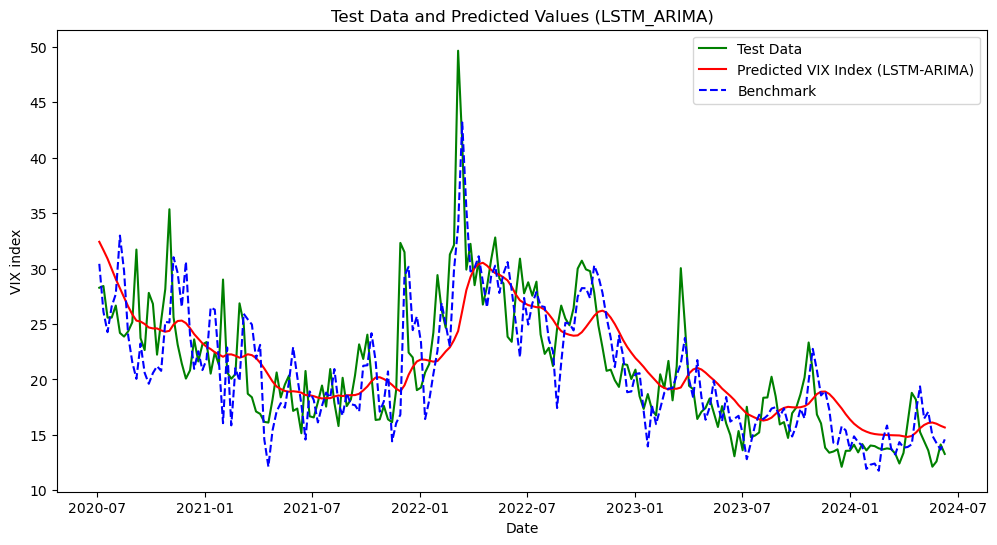

In [28]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[lookback:], test_data[lookback:], color='green', label='Test Data')
plt.plot(test_dates[lookback:], predicted_values_lstm_arima, color='red', linestyle='-', label='Predicted VIX Index (LSTM-ARIMA)')
plt.plot(test_dates[lookback:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')


plt.title('Test Data and Predicted Values (LSTM_ARIMA)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()


In [29]:
evaluation(test_data[lookback:], predicted_values_lstm_arima)

Performance Metrics:
Mean Squared Error (MSE): 16.202862247687012
Root Mean Squared Error (RMSE): 4.025277909373092
Mean Absolute Error (MAE): 2.9468433034137616
R-squared (R^2) Score: 0.5333214472566253


### Build_ARIMA-LSTM_model

In [30]:
# Train AutoARIMA model
history = [x[0] for x in predicted_values_lstm]
model = auto_arima(history, trace=True, error_action='ignore', suppress_warnings=True)
# Fit the model
model.fit(history)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=675.679, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=759.664, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=704.485, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=688.624, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=758.655, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=687.797, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=677.035, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=677.627, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=677.630, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=687.491, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=680.158, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=676.146, Time=0.20 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=675.105, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=687.323, 

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [31]:
#One_step ahead forecast
predicted_values_arima_lstm = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predicted_values_arima_lstm.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)


C:\Users\lenovo\AppData\Local\Temp\ipykernel_10952\3412609831.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_test_value = test_data[time_point]
E:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
E:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
E:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizatio

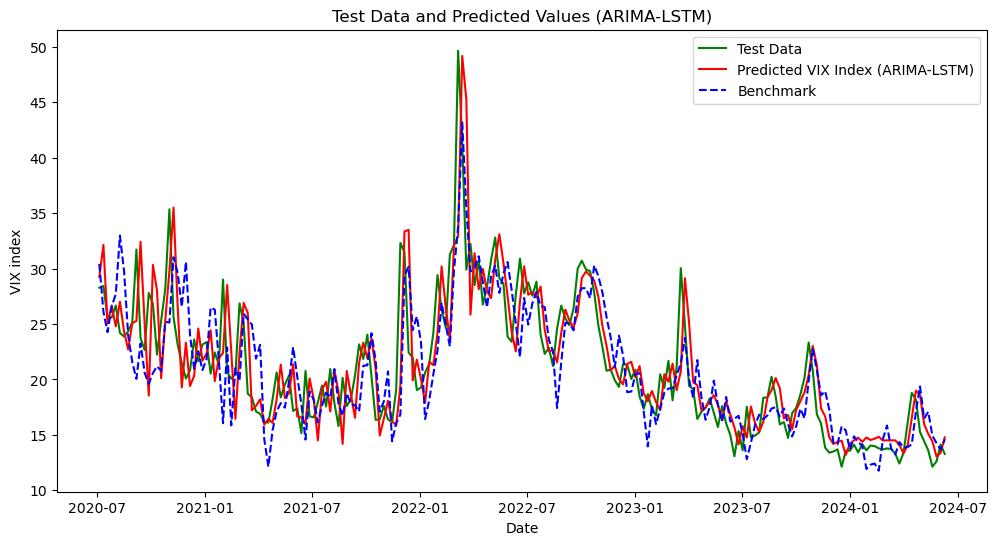

In [32]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[60:], test_data[60:], color='green', label='Test Data')
plt.plot(test_dates[60:], predicted_values_arima_lstm[60:], color='red', linestyle='-', label='Predicted VIX Index (ARIMA-LSTM)')
plt.plot(test_dates[60:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')


plt.title('Test Data and Predicted Values (ARIMA-LSTM)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()

In [33]:
evaluation(test_data, predicted_values_arima_lstm)

Performance Metrics:
Mean Squared Error (MSE): 23.546650626662046
Root Mean Squared Error (RMSE): 4.852489116593879
Mean Absolute Error (MAE): 2.8822657000667915
R-squared (R^2) Score: 0.6874628091410544


### Build_GRU-ARIMA_model

In [34]:
model1_predictions_series = pd.Series(predicted_values_arima, index=test_dates)
# Normalize the data
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(model1_predictions_series.values.reshape(-1, 1))

# Prepare the training data
lookback = 60  # Number of previous time steps to consider
X_train = []
y_train = []

for i in range(lookback, len(train_data_normalized)):
    X_train.append(train_data_normalized[i - lookback:i, 0])
    y_train.append(train_data_normalized[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data for GRU (batch_size, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the GRU model
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_gru.add(GRU(units=50))
model_gru.add(Dense(units=1))
optimizer = Adam(learning_rate=0.01)
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Train the GRU model
model_gru.fit(X_train, y_train, epochs=20, batch_size=32)

# Prepare the test data
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))

X_test = []
y_test = []

for i in range(lookback, len(test_data_normalized)):
    X_test.append(test_data_normalized[i - lookback:i, 0])
    y_test.append(test_data_normalized[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the input data for GRU (batch_size, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions on the test data
predicted_values_gru_arima = scaler.inverse_transform(model_gru.predict(X_test))

Epoch 1/20


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0177
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0074
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0054
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0044
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0041
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0033
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0036
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0040
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0031
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0034
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0035
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0042
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0037
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0041
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0034
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/

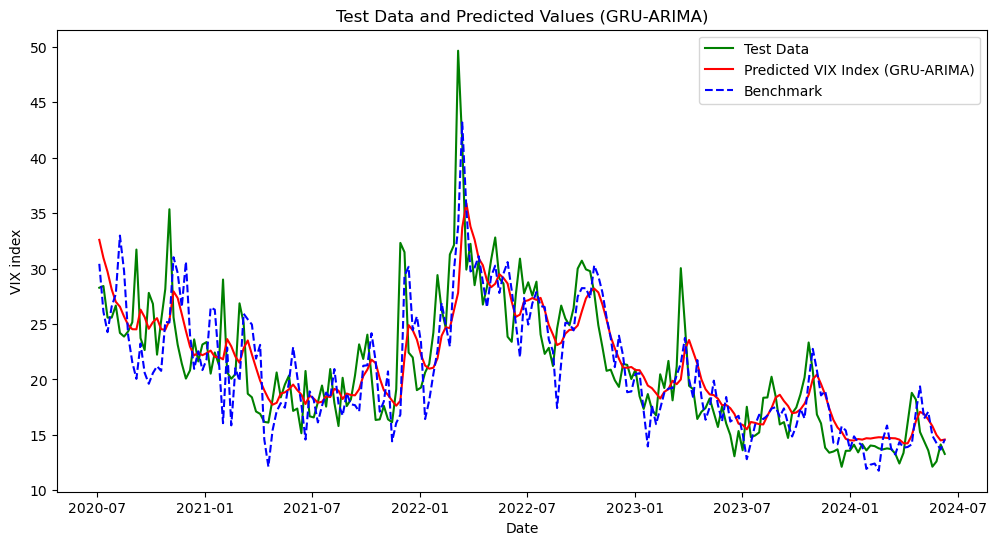

In [35]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[lookback:], test_data[lookback:], color='green', label='Test Data')
plt.plot(test_dates[lookback:], predicted_values_gru_arima, color='red', linestyle='-', label='Predicted VIX Index (GRU-ARIMA)')
plt.plot(test_dates[lookback:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')

plt.title('Test Data and Predicted Values (GRU-ARIMA)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
#plt.grid(True)
plt.show()

In [36]:
print(len(test_data))

266


In [37]:
print(len(predicted_values_gru_arima))

206


In [ ]:
evaluation(test_data, predicted_values_gru_arima)

### Build_ARIMA-GRU_model

In [38]:
# Train AutoARIMA model
history = [x[0] for x in predicted_values_gru]
model = auto_arima(history, trace=True, error_action='ignore', suppress_warnings=True)
# Fit the model
model.fit(history)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=956.788, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=970.906, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=972.818, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=972.747, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=969.196, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=954.821, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=959.800, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=961.407, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=956.802, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=956.805, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=955.168, Time=0.07 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=958.462, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=954.009, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=958.481, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=960.6

ARIMA(order=(1, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [42]:
#One_step ahead forecast
predicted_values_arima_gru = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(1,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predicted_values_arima_gru.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)


C:\Users\lenovo\AppData\Local\Temp\ipykernel_10952\4158190239.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_test_value = test_data[time_point]


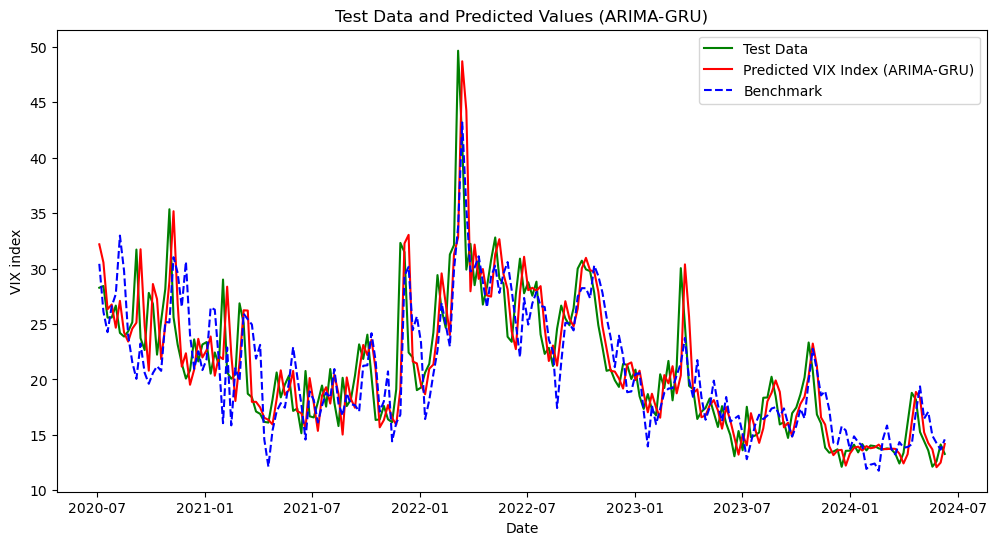

In [43]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(test_dates[60:], test_data[60:], color='green', label='Test Data')
plt.plot(test_dates[60:], predicted_values_arima_gru[60:], color='red', linestyle='-', label='Predicted VIX Index (ARIMA-GRU)')
plt.plot(test_dates[lookback:], predicted_values_mlp, color='blue', linestyle='--', label='Benchmark')

plt.title('Test Data and Predicted Values (ARIMA-GRU)')
plt.xlabel('Date')
plt.ylabel('VIX index')
plt.legend()
plt.show()

In [44]:
evaluation(test_data, predicted_values_arima_gru)

Performance Metrics:
Mean Squared Error (MSE): 18.11070712155243
Root Mean Squared Error (RMSE): 4.255667646980016
Mean Absolute Error (MAE): 2.601246994259571
R-squared (R^2) Score: 0.7596146637590175


## Strategies

### Combine_models_prediction_results

In [45]:
y_lstm = pd.Series([x[0] for x in predicted_values_lstm], index = test_dates[60:])
y_lstm_arima = pd.Series([x[0] for x in predicted_values_lstm_arima], index = test_dates[60:])
y_arima_lstm = pd.Series(predicted_values_arima_lstm[60:],index =test_dates[60:])
y_gru = pd.Series([x[0] for x in predicted_values_gru], index = test_dates[60:])
y_gru_arima = pd.Series([x[0] for x in predicted_values_gru_arima], index = test_dates[60:])
y_arima_gru = pd.Series(predicted_values_arima_gru[60:],index =test_dates[60:])
y_benchmark = pd.Series([x[0] for x in predicted_values_mlp], index = test_dates[60:])
y_test = test_data[60:]

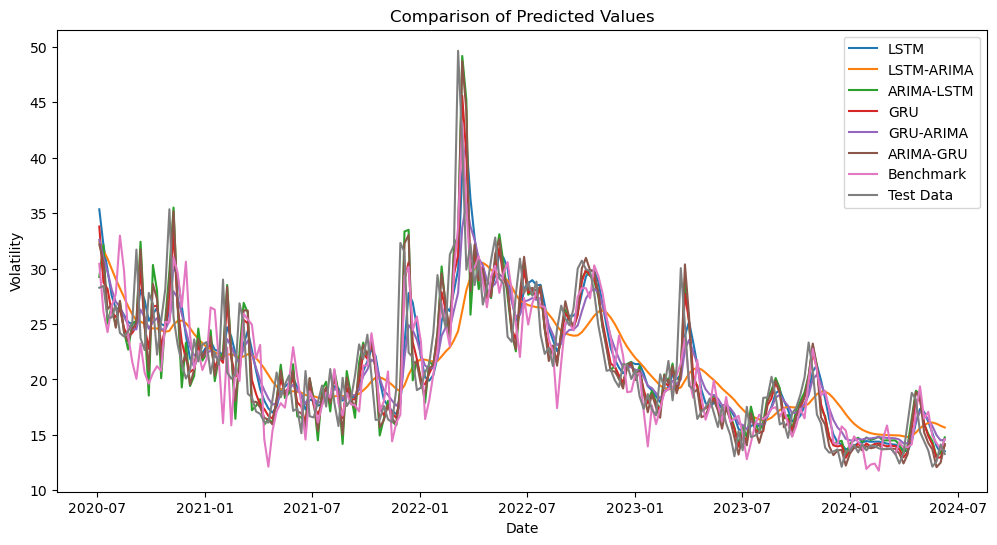

In [46]:
plt.figure(figsize=(12, 6))
# Plot the y-values
plt.plot(y_lstm, label='LSTM')
plt.plot(y_lstm_arima, label='LSTM-ARIMA')
plt.plot(y_arima_lstm, label='ARIMA-LSTM')
plt.plot(y_gru, label='GRU')
plt.plot(y_gru_arima, label='GRU-ARIMA')
plt.plot(y_arima_gru, label='ARIMA-GRU')
plt.plot(y_benchmark, label='Benchmark')
plt.plot(y_test, label='Test Data')

# Set the title and labels
plt.title('Comparison of Predicted Values')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()

# Display the plot
plt.show()

In [47]:
models = ["Benchmark",'LSTM', 'LSTM_ARIMA', 'ARIMA_LSTM', 'GRU', 'GRU_ARIMA', 'ARIMA_GRU',"Test_data"]
predictions = [y_benchmark, y_lstm, y_lstm_arima, y_arima_lstm, y_gru, y_gru_arima, y_arima_gru,y_test]

data_vol = {model: prediction for model, prediction in zip(models, predictions)}

# Create the DataFrame
df_vol = pd.DataFrame(data_vol)

In [48]:
df_vol

,Benchmark,LSTM,LSTM_ARIMA,ARIMA_LSTM,GRU,GRU_ARIMA,ARIMA_GRU,Test_data
Date,,,,,,,,
2020-07-05,30.425539,35.338371,32.409714,29.235984,33.791023,32.586792,32.183876,28.2699
2020-07-12,26.109354,32.128162,31.664637,32.132704,28.754766,30.966402,30.545996,28.4276
2020-07-19,24.262878,29.838047,30.885845,25.025679,28.160580,29.706129,26.330517,25.5762
2020-07-26,26.584034,27.560928,29.974865,26.672199,26.043354,28.126112,26.758878,25.5773
2020-08-02,27.700068,26.383593,29.048275,24.777242,25.633778,27.000341,24.667900,26.6625
...,...,...,...,...,...,...,...,...
2024-05-12,17.085281,16.199575,16.073254,15.092135,14.902733,16.390308,14.268210,13.6018
2024-05-19,14.928338,15.174349,16.119543,14.423173,14.143384,15.795745,13.691736,12.1346
2024-05-26,14.266808,14.011388,16.008112,13.050927,12.952686,14.992024,12.088698,12.6094


### Evaluation_method_index_metrics

In [49]:
#Evaluation method 1: index metrics (Prediction accuracy) Ref: Main1
#1 Testing accuracy ratio for modelling (bar plot/box plot)
#2 MSE, RMSE, MAE, etc...

In [50]:
# Calculate statistical measures for each model
metrics = ['MSE', 'RMSE', 'MAE', 'Correlation', 'Cosine Similarity', 'R-squared']
results = []

for column in df_vol.columns[:-1]:  # Exclude the 'Test_data' column
    model_data = df_vol[column]
    test_data = df_vol['Test_data']
    
    # Calculate statistical measures
    mse = np.mean((model_data - test_data) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(model_data - test_data))
    correlation = np.corrcoef(model_data, test_data)[0, 1]
    cosine_similarity = np.dot(model_data, test_data) / (np.linalg.norm(model_data) * np.linalg.norm(test_data))
    
    # Calculate R-squared
    ss_res = np.sum((test_data - model_data) ** 2)
    ss_tot = np.sum((test_data - np.mean(test_data)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Store the results
    results.append([mse, rmse, mae, correlation, cosine_similarity, r_squared])

# Create a DataFrame to display the results
df_results = pd.DataFrame(results, columns=metrics, index=df_vol.columns[:-1])

# Sort the models based on the similarity metrics (choose the desired metric as per your preference)
df_results_sorted_vol = df_results.sort_values(by='MSE', ascending=True)

In [51]:
df_results_sorted_vol

,MSE,RMSE,MAE,Correlation,Cosine Similarity,R-squared
GRU,10.254925,3.202331,2.219246,0.843710,0.989267,0.704635
ARIMA_GRU,11.633810,3.410837,2.354366,0.835592,0.987927,0.664920
GRU_ARIMA,12.310192,3.508588,2.566909,0.804756,0.987111,0.645439
LSTM,12.480282,3.532744,2.552400,0.810053,0.987233,0.640540
ARIMA_LSTM,12.606409,3.550551,2.510436,0.817269,0.987012,0.636907
Benchmark,15.576631,3.946724,2.920424,0.761229,0.983599,0.551358
LSTM_ARIMA,16.202862,4.025278,2.946843,0.732246,0.983005,0.533321


In [52]:
df_vol

,Benchmark,LSTM,LSTM_ARIMA,ARIMA_LSTM,GRU,GRU_ARIMA,ARIMA_GRU,Test_data
Date,,,,,,,,
2020-07-05,30.425539,35.338371,32.409714,29.235984,33.791023,32.586792,32.183876,28.2699
2020-07-12,26.109354,32.128162,31.664637,32.132704,28.754766,30.966402,30.545996,28.4276
2020-07-19,24.262878,29.838047,30.885845,25.025679,28.160580,29.706129,26.330517,25.5762
2020-07-26,26.584034,27.560928,29.974865,26.672199,26.043354,28.126112,26.758878,25.5773
2020-08-02,27.700068,26.383593,29.048275,24.777242,25.633778,27.000341,24.667900,26.6625
...,...,...,...,...,...,...,...,...
2024-05-12,17.085281,16.199575,16.073254,15.092135,14.902733,16.390308,14.268210,13.6018
2024-05-19,14.928338,15.174349,16.119543,14.423173,14.143384,15.795745,13.691736,12.1346
2024-05-26,14.266808,14.011388,16.008112,13.050927,12.952686,14.992024,12.088698,12.6094


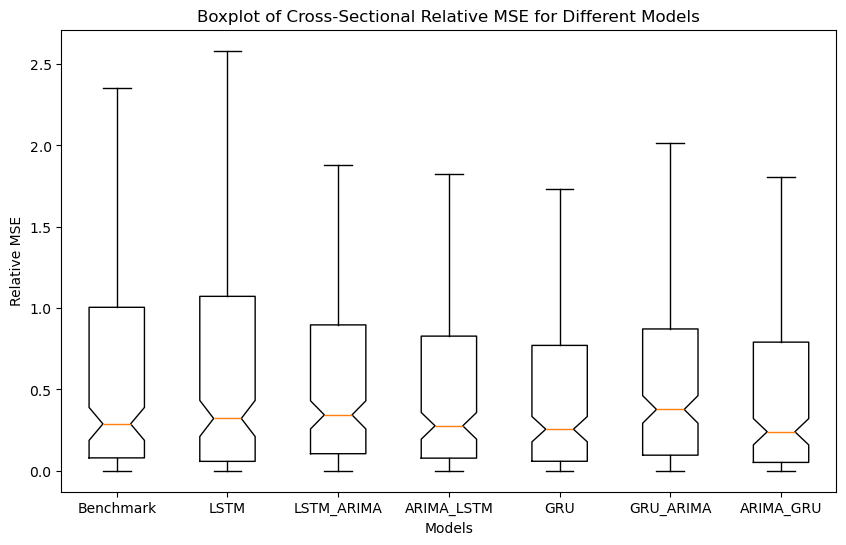

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate relative MSE for each model
models = df_vol.columns[:-1]  # Extract the model names from df_vol
relative_mse_values = []

for model in models:
    mse_values = (df_vol['Test_data'] - df_vol[model]) ** 2
    relative_mse = mse_values / np.mean(mse_values)
    relative_mse_values.append(relative_mse)

# Create boxplots of relative MSE for different models
plt.figure(figsize=(10, 6))
plt.boxplot(relative_mse_values, vert=True, showfliers=False, notch=True, labels=models)
plt.xlabel('Models')
plt.ylabel('Relative MSE')
plt.title('Boxplot of Cross-Sectional Relative MSE for Different Models')
plt.show()
